# Customer Segmentation using Clustering


In [4]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")


# Data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [6]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [8]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


# Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer.



In [10]:
df = pd.merge(df_offers, df_transactions)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   offer_id       324 non-null    int64 
 1   campaign       324 non-null    object
 2   varietal       324 non-null    object
 3   min_qty        324 non-null    int64 
 4   discount       324 non-null    int64 
 5   origin         324 non-null    object
 6   past_peak      324 non-null    bool  
 7   customer_name  324 non-null    object
 8   n              324 non-null    int64 
dtypes: bool(1), int64(4), object(4)
memory usage: 23.1+ KB


In [14]:
customers = pd.pivot_table(df, index='customer_name', columns = 'offer_id', values = 'n', fill_value = 0)
customers.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


# K-Means Clustering

Recall that in K-Means Clustering we want to maximize the distance between centroids and minimize the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

## Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned.

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$
where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the elbow point in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly.

## What values of SS do you believe represent better clusterings? Why?

Sum-of-squares(SS) will get smaller as the number of clusters gets larger and the sizes of the individual clusters gets smaller. Smaller values of SS represent better clusterings up to a certain point. We are trying to find general categories and if there are too many clusters, we defeat that purpose.

A good clustering has tight clusters, meaning that the samples in each cluster are bunched together, not spread out. How spread out the samples within each cluster are can be measured by the 'inertia'. A good rule of thumb for 'how many clusters to choose?:

to choose an elbow in the inertia plot where inertia begins to decrease more slowly.
## Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)

In [26]:
x_cols = customers.to_numpy()

In [27]:

x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

## Write code that applies the KMeans clustering method from scikit-learn to this matrix.

In [30]:
K_range = range(2,11)
SS = []
for k in K_range:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    SS.append(model.inertia_)

Construct a plot showing SS for each K and pick K using this plot. For simplicity, test 2 <= K <= 10.

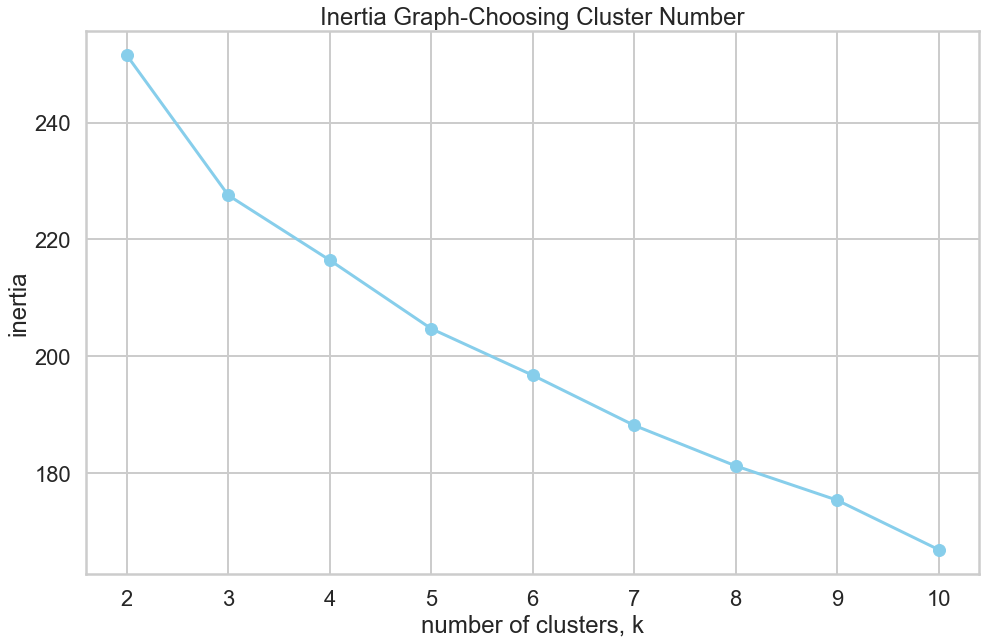

In [32]:
plt.figure(figsize=(16,10))
plt.plot(K_range, SS, '-o', color = 'skyblue')
plt.title('Inertia Graph-Choosing Cluster Number')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(K_range)
plt.show()

According to 'elbow' technique, I have choosen 4 as the best K number even though there were other candidates.

# Make a bar chart showing the number of points in each cluster for k-means under the best K.

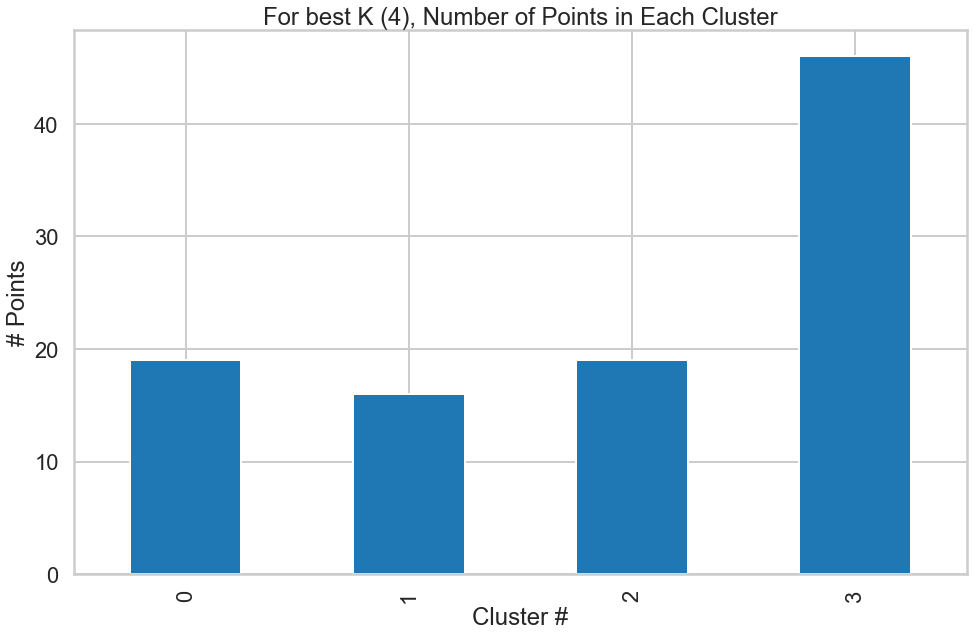

In [34]:
cluster = KMeans(n_clusters=4)

customers['cluster'] = cluster.fit_predict(x_cols)

plt.figure(figsize=(16,10))
ax = customers.cluster.value_counts().sort_index().plot.bar()
plt.title("For best K (4), Number of Points in Each Cluster")
plt.xlabel("Cluster #")
plt.ylabel("# Points")
plt.show()


## What challenge did you experience using the elbow method to pick K?

I have experienced challenges when I tried to figure out the K value via elbow-method. There were multiple points in the graph where there was a bend. For the best K, I have just choosen the bend that had the steepest slope since it showed significant decrease within cluster sum-of-squares.

## Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster and also how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the average distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$
The silhouette score is computed on every datapoint in every cluster. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.


Range	Interpretation
0.71 - 1.0	A strong structure has been found.
0.51 - 0.7	A reasonable structure has been found.
0.26 - 0.5	The structure is weak and could be artificial.
< 0.25	No substantial structure has been found.
</pre> Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called sklearn.metrics.silhouette_score. Take a look at this article on picking $K$ in scikit-learn, as it will help you in the next exercise set.




Range	Interpretation

0.71 - 1.0	A strong structure has been found.

0.51 - 0.7	A reasonable structure has been found.

0.26 - 0.5	The structure is weak and could be artificial.

< 0.25	No substantial structure has been found.

Fortunately, scikit-learn provides a function to compute this for us (phew!) called sklearn.metrics.silhouette_score.

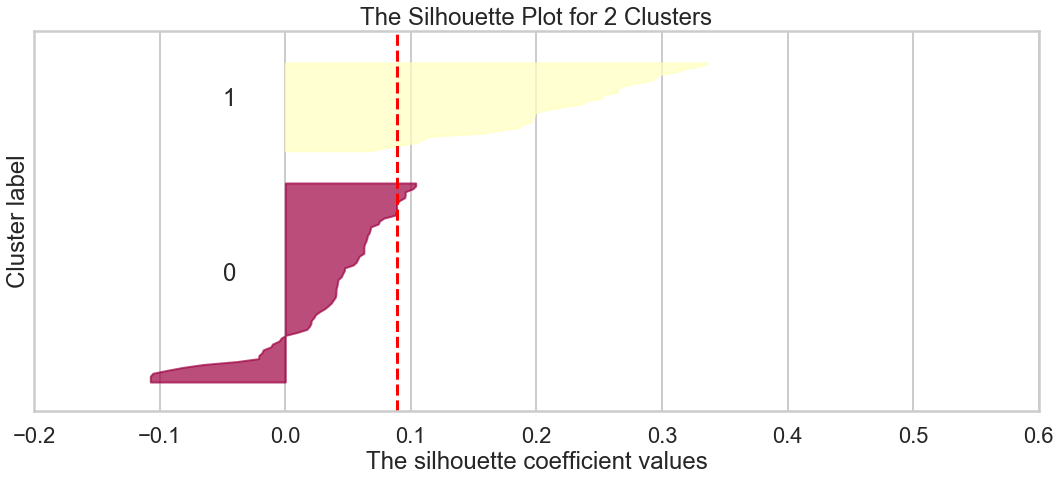

For n_clusters = 2, the average silouette score is: 0.08911656187360473


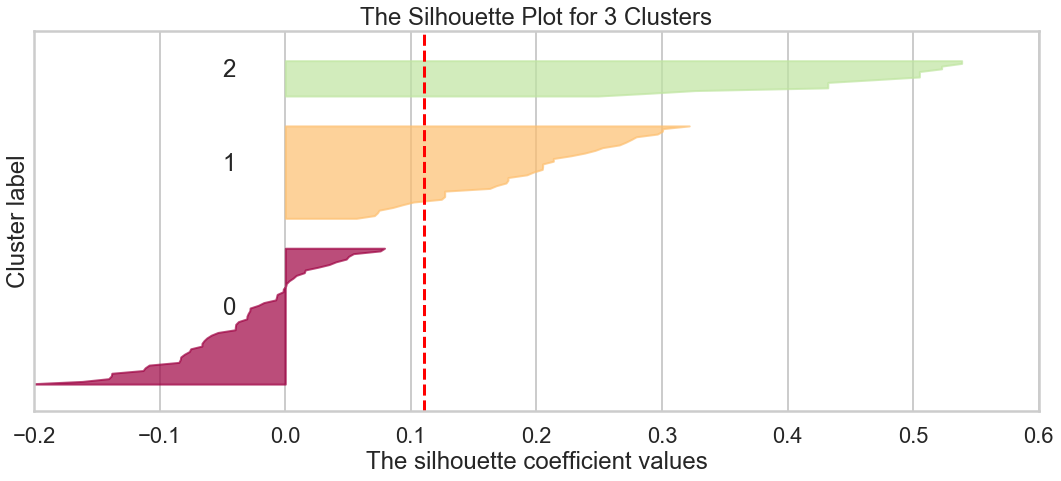

For n_clusters = 3, the average silouette score is: 0.11015391298263667


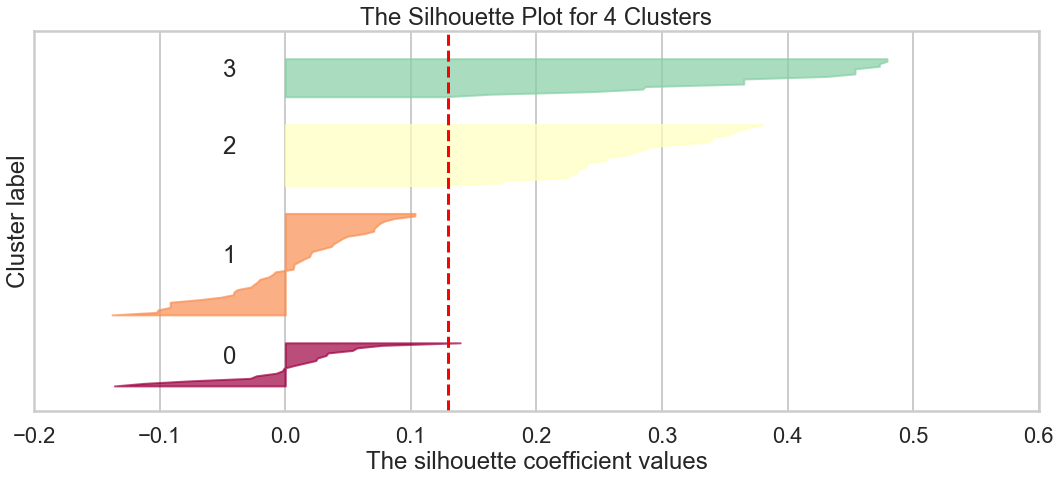

For n_clusters = 4, the average silouette score is: 0.12941883590155936


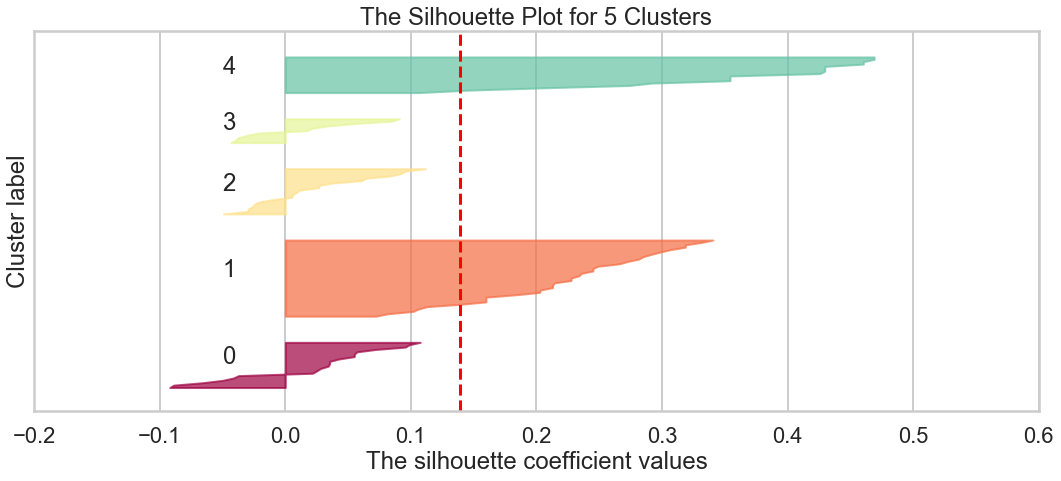

For n_clusters = 5, the average silouette score is: 0.13911006290392372


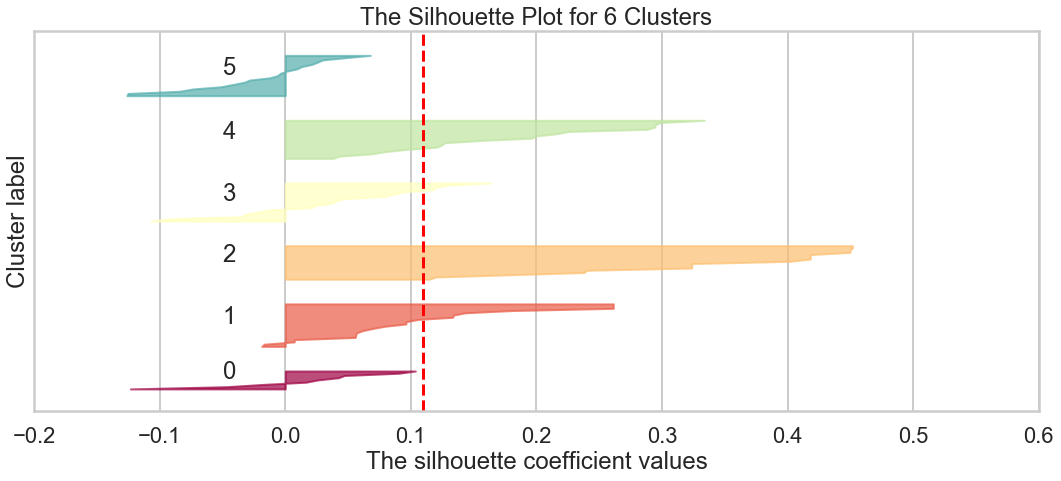

For n_clusters = 6, the average silouette score is: 0.10979895247757922


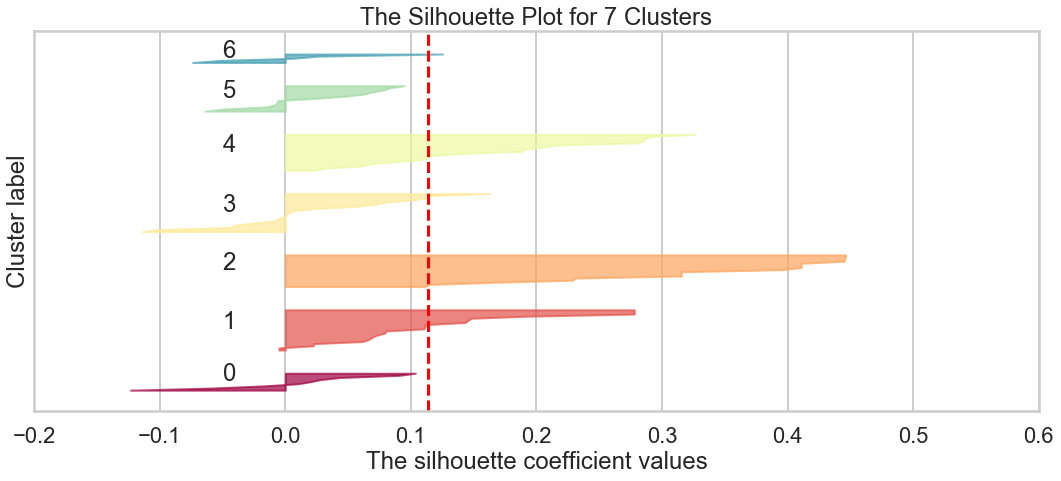

For n_clusters = 7, the average silouette score is: 0.11326943929616652


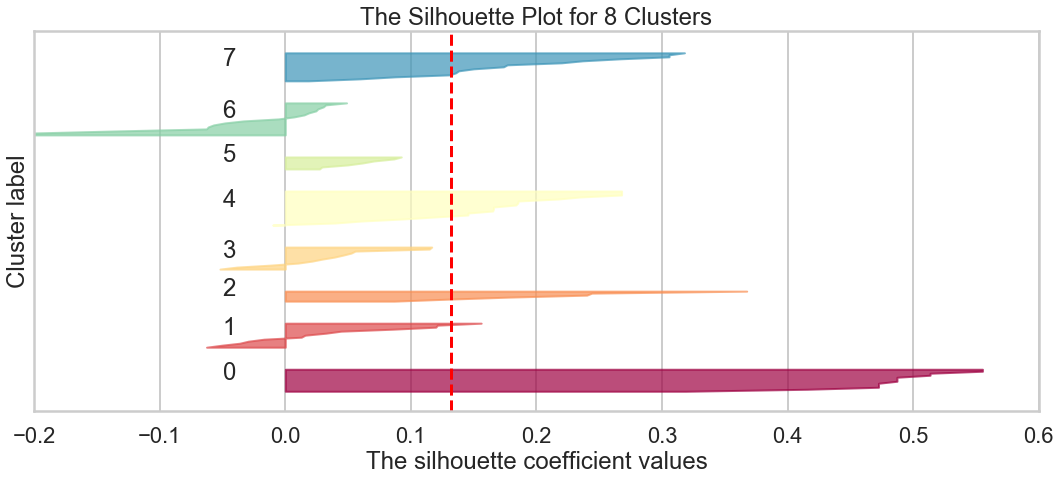

For n_clusters = 8, the average silouette score is: 0.13198496281110994


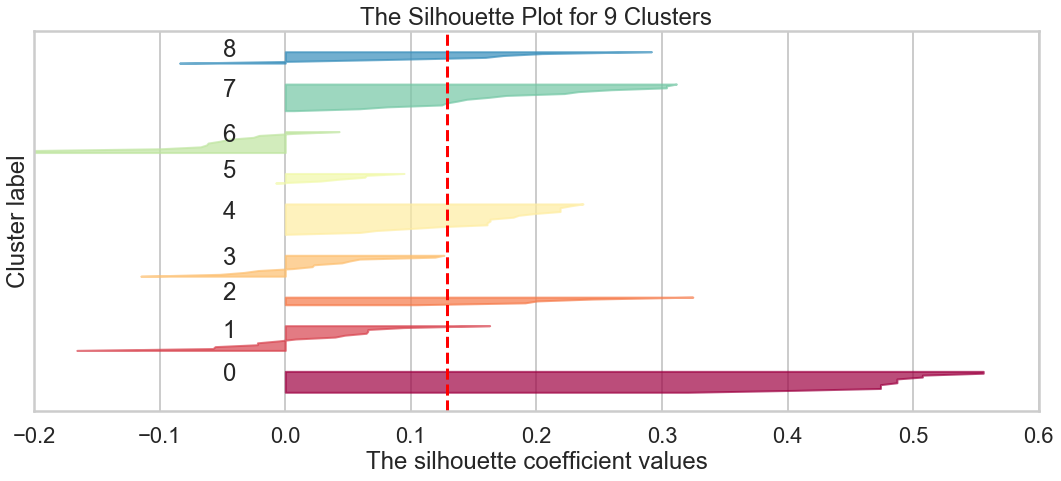

For n_clusters = 9, the average silouette score is: 0.1291115731137975


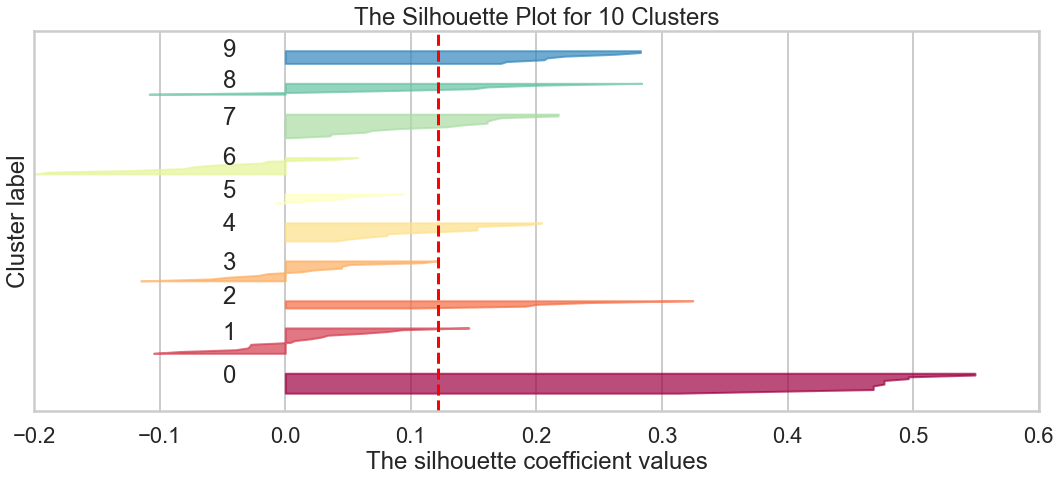

For n_clusters = 10, the average silouette score is: 0.1216086963107709


In [35]:

from sklearn import metrics
import matplotlib.cm as cm

silhouette = []
for k in K_range:
    
    # Estimate K-means clustering and compute the silouette scores
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(x_cols)
    silhouette_score = metrics.silhouette_score(x_cols, cluster_labels, metric='euclidean')
    sample_silhouette_values = metrics.silhouette_samples(x_cols, cluster_labels)
    silhouette.append(silhouette_score)
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(18,7)
    
    # Silouette plot
    ax.set_xlim([-0.2, 0.6])
    ax.set_ylim([0, len(customers) + (k + 1) * 10])
    
    y_lower = 10
    for i in range(k):
        cluster_i = sample_silhouette_values[cluster_labels == i]
        size_cluster_i = len(cluster_i)
        cluster_i.sort()
      
        y_upper = y_lower + size_cluster_i
        
        color = cm.Spectral(float(i)/k)
        ax.fill_betweenx(np.arange(y_lower,y_upper), 0, cluster_i, facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        
        y_lower = y_upper + 10
        
    ax.set_title("The Silhouette Plot for {} Clusters".format(k))
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

    plt.show() 
    print('For n_clusters = {}, the average silouette score is: {}'.format(k, silhouette_score))

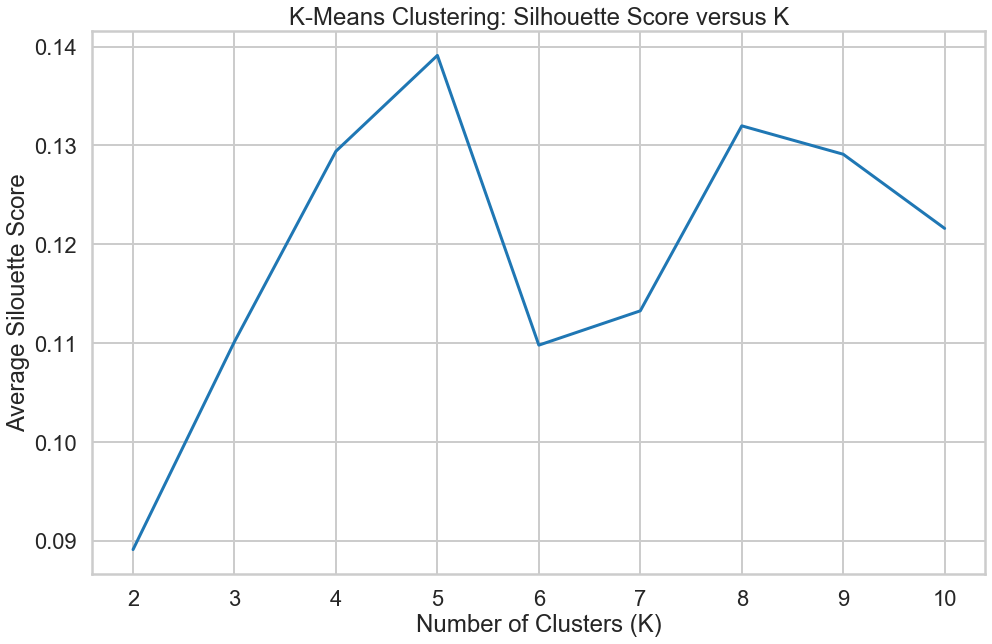

In [36]:

# Plot Silhouette Scores against K number of clusters
plt.figure(figsize=(16,10))
plt.plot(K_range, silhouette)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silouette Score')
plt.title('K-Means Clustering: Silhouette Score versus K')
plt.show()

## Response:

For n_clusters = 4, the average silouette score is: 0.13421536289944658

For n_clusters = 7, the average silouette score is: 0.1389060957347788

The average silhouette score is less than 0.14 regardless of the number of clusters, suggesting that there is no clear structure or pattern in the data. Setting $K = 4$ clusters seems to yield a relatively better silhouette score than if $K$ is two, three, five or six. But $K = 7$ yields a slightly higher silhouette score, which silhouette_score method pinpoints as a best cluster number.

# Visualizing Clusters using PCA
How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

C:\Users\senih\anaconda3\lib\site-packages\pandas\core\indexes\base.py:3941: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


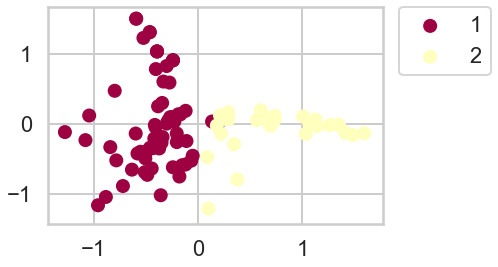

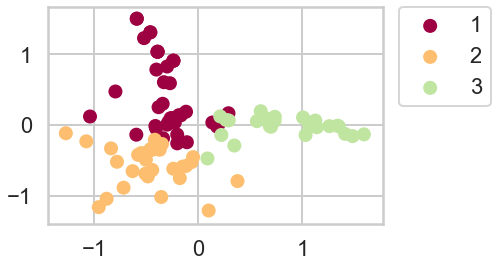

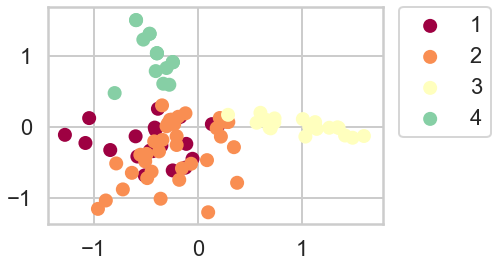

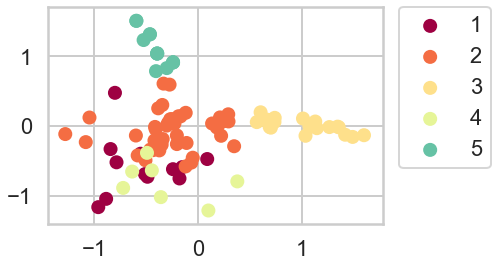

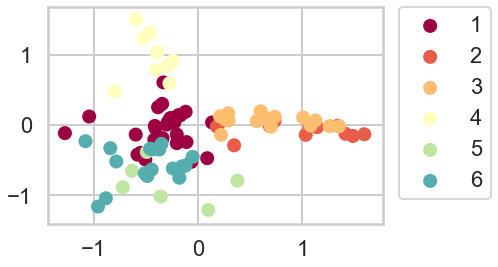

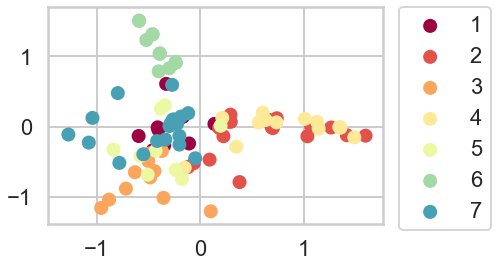

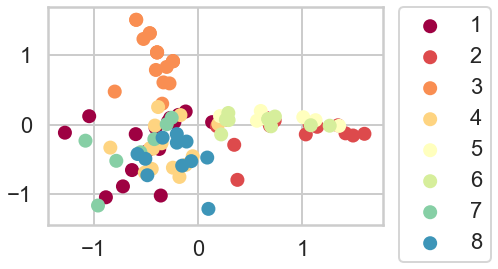

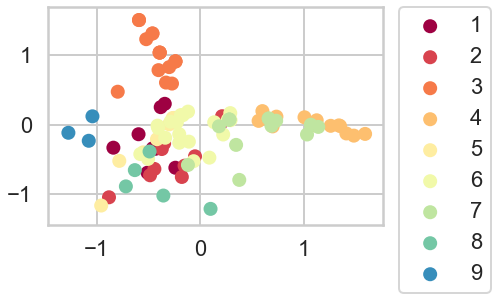

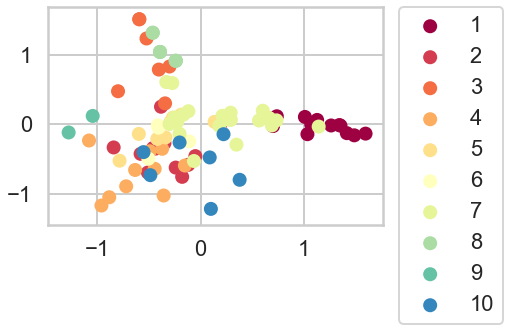

In [37]:
from sklearn.decomposition import PCA

model = PCA(n_components=2)
x,y = zip(*model.fit_transform(x_cols))
new_table = customers.copy()
new_table['x']=x
new_table['y']=y
item_columns = new_table.columns[[range(32)]]
new_table = new_table.drop(item_columns,axis=1)

for chosen_k in K_range:

    model = KMeans(n_clusters = chosen_k)
    model.fit_transform(x_cols)
    labels = model.labels_
    new_table['cluster_id'] = labels
    new_table.head()

    fig,ax = plt.subplots()
    for i in range(chosen_k):
        color = cm.Spectral(new_table['cluster_id'][labels==i]/float(chosen_k))
        ax.scatter(new_table['x'][labels==i],new_table['y'][labels==i]
                ,color=color
                ,label=i)
    ax.legend(labels=range(1,chosen_k+1),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [39]:
new_table.head(10)

offer_id,cluster,x,y,cluster_id
customer_name,,,,
Adams,2,1.007580,0.108215,0
Allen,3,-0.287539,0.044715,4
Anderson,1,-0.392032,1.038391,7
Bailey,2,0.699477,-0.022542,0
Baker,3,0.088183,-0.471695,9
Barnes,0,-0.485282,-0.725503,9
Bell,1,-0.591941,1.506500,2
Bennett,3,0.661732,0.090308,6
Brooks,3,-0.118943,-0.577499,1


The clusters have many overlaps with greater number of clusters. Based on what I see, the best value for K seems to be 4. Moreover, the silhouette method seems to have produced the optimal result visually since it has more details on clusters, their sizes, how different number of clusters distribute data in 2-D space.

## Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [40]:
new_df = pd.merge(df, new_table, on = 'customer_name')

In [42]:
new_df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster,x,y,cluster_id
0,1,January,Malbec,72,56,France,False,Thomas,1,0,-1.041879,0.122314,8
1,4,February,Champagne,72,48,France,True,Thomas,1,0,-1.041879,0.122314,8
2,9,April,Chardonnay,144,57,Chile,False,Thomas,1,0,-1.041879,0.122314,8
3,11,May,Champagne,72,85,France,False,Thomas,1,0,-1.041879,0.122314,8
4,14,June,Merlot,72,64,Chile,False,Thomas,1,0,-1.041879,0.122314,8


In [43]:

# Define cluster numbers
new_df['cluster'].unique() # Four clusters

array([0, 1, 3, 2])

In [44]:
# group the data by cluster and then varietal
new_df_sorted = new_df.groupby(['cluster','varietal'], as_index=False).n.agg(np.sum)

C:\Users\senih\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\senih\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 48.91999999999997, 'Cluster')

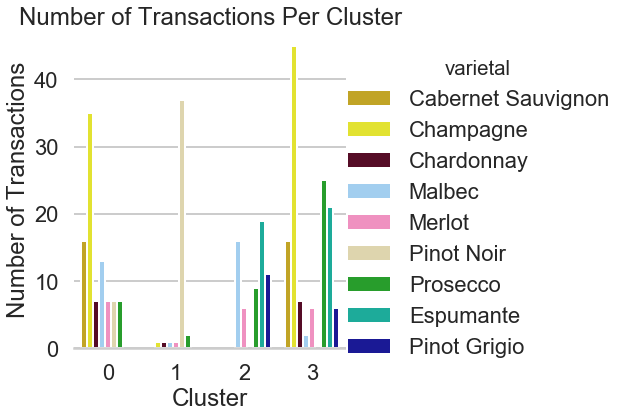

In [45]:
# create a plot of the grouped data

#create a color palette that includes at least 9 unique colors
colors = ["gold", "yellow", "burgundy", "light blue", "pink", "beige", "green", "turquoise", "royal blue" ]
new_palette = sns.xkcd_palette(colors)
sns.set_palette(new_palette)

# make a seaborn factorplot
g = sns.factorplot(x = 'cluster', y = 'n', hue = 'varietal', kind = 'bar', data = new_df_sorted, size = 6) 
g.despine(left = True)
plt.title('Number of Transactions Per Cluster')
plt.ylabel("Number of Transactions")
plt.xlabel("Cluster")

Text(0, 0.5, 'Number of Transactions')

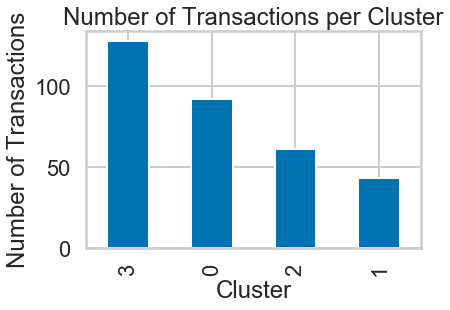

In [47]:
# make a bar graph of number of transactions per cluster
sns.set_palette('colorblind')
num_per_cluster = new_df.cluster.value_counts()
num_per_cluster.plot(kind='bar') 
plt.title('Number of Transactions per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Transactions')

# Comment:

$Cluster '0'$ consists of 6 varietal, which are Cabernet Sauvignon, Champagne, Chardonnay, Espumante, Merlot, Prosecco. This cluster purchased the most amount of Champagne. This cluster has the third highest number of transactions. This cluster purchases mostly France varietal.

$Cluster '1'$ consists of 8 varietal, which are Cabernet Sauvignon, Champagne, Chardonnay, Espumante, Merlot, Prosecco, Malbec, Pinot Grigio. This cluster purchased the most amount of Espumante, Prosecco, Malbec, Pinot Grigio. This cluster has the second highest number of transactions. Their purchase of varietal seems more steady than other clusters. This cluster purchases mostly France and Oregon varietal.

$Cluster '2'$ consists of 6 varietal, which are Champagne, Chardonnay, Merlot, Prosecco, Marlec, Pinor Noir. This cluster purchased the most amount of Pinor Noir. Other varietals in this cluster have very low transactions. This cluster generally enjoys Pinor Noir, but does not enjoy other varietals much at all and also has the lowest number of transactions. This cluster purchases mostly Australia varietal.

$Cluster '3'$ consists of 9 varietal, which are Cabernet Sauvignon, Champagne, Chardonnay, Espumante, Merlot, Prosecco, Malbec, Pinot Grigio, and Pinot Noir. This cluster purchases the most amount of Cabernet Sauvigno and also great amount of champagne. This cluster has the highest number of transactions. This cluster purchases mostly France varietal.

Cabernet Sauvignon, Champagne, Chardonnay, Merlot and Prosecco are the common varietal in all clusters. Namely, we can say that all cluster enjoys generally France, Chille, and California varietal.